In [4]:
import math   # for sqrt
import random # for random sampling


# -----------------------------
# Part 1: k-means implementation
# -----------------------------
def get_distance(point1, point2):
    """
    Compute the Euclidean distance between two points.
    """
    # sum of squared differences
    square_sum = 0 # sum of squared differences
    #Iterate over each dimension of the two points together.
    for x, y in zip(point1, point2):
        square_sum += (x - y) ** 2  # add squared difference
    
    #return square root of square_sum
    return math.sqrt(square_sum)

def initialize_centroids(data, k, seed=2025):
    """
    Select k initial centroids randomly from the data.
    """

    #Set the random seed for reproducibility.
    random.seed(seed)

    #Number of data points.
    n = len(data)

    #Randomly choose k distinct indices from 0 to n-1.
    indices = random.sample(range(n), k)

    centroids = [] # List to store chosen centroids.

    #Use the selected indices to pick points from the data.
    for idx in indices:
        centroids.append(data[idx])

    return centroids

def assign_points(data, centroids):
    """
    Assign each data point to the nearest centroid.
    """
    assignments = [] # List to store cluster index for each point.

    # Iterate over all data points.
    for point in data:
        min_dist = float("inf") # Current minimum distance (start with infinity).

        closest_cluster = None # Index of the closest centroid.

        # Compare the point with each centroid.
        for cluster_idx, centroid in enumerate(centroids):
            dist = get_distance(point, centroid) # Use the distance function.

            if dist < min_dist:
                min_dist = dist
                closest_cluster = cluster_idx

        #After checking all centroids, assign the point to the closest cluster.
        assignments.append(closest_cluster)

    return assignments

def compute_new_centroids(data, assignments, k):
    """
    Compute new centroids as the mean of points in each other.
    """

    # Number of features (dimensions).
    num_dimensions = len(data[0])

    # Prepare lists to store sums and counts for each cluster.
    sums = [[0.0] * num_dimensions for _ in range(k)]
    counts = [0] * k

    # Accumulate sums and counts for each cluster.
    for point, cluster_idx in zip(data, assignments):
        counts[cluster_idx] += 1
        for d in range(num_dimensions):
            sums[cluster_idx][d] += point[d]

    # Compute the mean for each cluster.
    new_centroids = []

    for cluster_idx in range(k):
        if counts[cluster_idx] == 0:
            # If a cluster has no points, handle it in a simple way.
            new_centroids.append(random.choice(data))
        else:
            centroid = []
            for d in range(num_dimensions):
                mean_value = sums[cluster_idx][d] / counts[cluster_idx]

                centroid.append(mean_value)
            new_centroids.append(centroid)

    return new_centroids


def has_converged(old_centroids, new_centroids, tol=1e-6):
    """
    Check if centroids have stopped changing.
    """

    # Compare each old centroid with the corresponding new centroid.
    for c_old, c_new in zip(old_centroids, new_centroids):
        # Compare coordinated-by-coordinate within tolerance.
        for x, y in zip(c_old, c_new):
            if abs(x - y) > tol:
                # If difference is greater than tolerance -> not converged.
                return False
    
    # All coordinates are within tolerance -> converged.
    return True

def k_means(data, k, max_iters=100, seed=2025):
    """
    Run the k-means clustering algorithm.
    data : list of points (each point is a list of numbers)
    k : number of clusters
    max_iters : maximum number of iterations
    seed : random seed for centroid initialization
    """

    # 1. Initialize centroids.
    centroids = initialize_centroids(data, k , seed=seed)

    for iteration in range(max_iters):
        # 2. Assign each point to the nearest centroid.
        assignments = assign_points(data, centroids)

        # 3. Compute new centroids based on current assignments.
        new_centroids = compute_new_centroids(data, assignments, k)

        # 4. Check for convergence.
        if has_converged(centroids, new_centroids, tol=1e-6):
            centroids = new_centroids
            break

        # Update centroids for the next iterations.
        centroids = new_centroids

    return centroids, assignments

## Part 2: Algorithm Application

In [7]:
# -----------------------------
# Part 2: Apply algorithm to Tokyo Airbnb
# -----------------------------
def load_airbnb_data(csv_path):
    """
    Load Airbnb dataset from CSV and perform basing cleaning.
    """
    import pandas as pd

    # Read CSV file using pandas.
    df = pd.read_csv(csv_path)

    # Select only required columns.
    required_cols = ["latitude", "longitude", "price", "room_type"]
    df = df[required_cols].copy()

    # 1) Ensure latitude & longitude are numeric
    # If there are any non-numeric values, they become NaN and will be dropped later.
    df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

    
    # 2) Convert price values to string (in case of mixed numeric/string formats)
    df["price"] = df["price"].astype(str)

    # 3) Remove currency symbols ($, €, ₩ etc.) and commas
    df["price"] = df["price"].str.replace(r"[^0-9\.]", "", regex=True)

    # 4) Convert cleaned string to numeric (values that cannot be converted become NaN)
    df["price"] = pd.to_numeric(df["price"], errors="coerce")

    # Drop rows that contain missing values in essential columns.
    df = df.dropna(subset=["latitude", "longitude", "price", "room_type"])
    

    print("Number of rows after cleaning:", len(df))
    print("Columns:", df.columns)

    # Return cleaned Dataframe.
    return df

def run_clustering_on_airbnb(df, k=4):
    """
    Apply k-means clustering to Airbnb dataset.
    """
    print("Number of rows received in run_clustering_on_airbnb:", len(df))

    if len(df) < k:
        print(f"Warning: number of rows ({len(df)}) is smaller than k={k}.")
        print("Please check the data cleaning step or choose a smaller k.")
        return df  # 그냥 그대로 반환하고 k-means는 실행하지 않음

    # Convert Dataframe to plain Python list for k-means input.
    data_for_clustering = []

    for _, row in df.iterrows():
        # Use latitude, longitude, price as features.
        point = [row["latitude"], row["longitude"], row["price"]]
        data_for_clustering.append(point)
    
    print("Number of points in data_for_clustering:", len(data_for_clustering))

    # Run k-means algorithm (from Part 1).
    centroids, assignments = k_means(data_for_clustering, k=k, max_iters=100, seed=2025)

    # Add cluster assignment to Dataframe.
    df["cluster"] = assignments

    # Save result as a new CSV.
    output_path = "listings_with_clusters.csv"
    df.to_csv(output_path, index=False)

    # Return Dataframe with cluster column.
    return df

def main():
    # 1. Load CSV
    csv_path = "listings.csv"
    airbnb_df = load_airbnb_data(csv_path)

    # 2. k-means
    clustered_df = run_clustering_on_airbnb(airbnb_df, k=4)

    # Print check
    print(clustered_df.head())
    print("Clustering and CSV save complete!")

if __name__ == "__main__":
    main()

Number of rows after cleaning: 23260
Columns: Index(['latitude', 'longitude', 'price', 'room_type'], dtype='object')
Number of rows received in run_clustering_on_airbnb: 23260
Number of points in data_for_clustering: 23260
    latitude   longitude     price        room_type  cluster
0  35.706170  139.745120  100000.0  Entire home/apt        3
1  35.706254  139.745134  100000.0  Entire home/apt        3
2  35.698540  139.780864   14550.0  Entire home/apt        2
3  35.755420  139.732600   22012.0  Entire home/apt        2
4  35.715503  139.808758   15429.0  Entire home/apt        2
Clustering and CSV save complete!


## Part 3: Data Analysis

In [10]:
# -----------------------------
# Part 3: Analysis & plots
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt

def load_clustered_data(csv_path="listings_with_clusters.csv"):
    """
    Load the Airbnb Tokyo dataset that already includes cluster assignments.
    This file was generated in Part 2 after running k-means.
    """
    df = pd.read_csv(csv_path)
    return df


# Question 1) Why is one cluster more expensive than the others?
def analyze_prices_by_cluster(df):
    """
    Compute and print mean and median prices by cluster.
    Higher average prices may indicate:
    - desirable or central geographic location,
    - different composition of room types,
    - higher demand or tourist-heavy areas.
    """
    # Calculate mean price for each cluster
    mean_price = df.groupby("cluster")["price"].mean()

    # Calculate median price for each cluster
    median_price = df.groupby("cluster")["price"].median()

    print("Mean price by cluster:")
    print(mean_price)

    # Identify which cluster has the highest average price
    high_cluster = mean_price.idxmax()
    print(f"\nCluster with highest mean price: {high_cluster}")

    return mean_price, median_price, high_cluster


# Question 2) Do clusters differ in their composition of room types?
def analyze_room_type_by_cluster(df):
    """
    Count room types for each cluster.
    """
    # Count room types per cluster
    counts = pd.crosstab(df["cluster"], df["room_type"])

    print("\nRoom type counts by cluster:")
    print(counts)

    # Convert to proportions for better interpretation
    proportions = counts.div(counts.sum(axis=1), axis=0)

    print("\nRoom type proportions by cluster:")
    print(proportions)

    return counts, proportions


# Question 3) Scatter plot of all listings colored by cluster.
def plot_clusters(df):
    """
    This visualizes how clusters are geographically distributed in Tokyo.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(df["longitude"], df["latitude"], c=df["cluster"], s=5)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tokyo Airbnb Listings by Cluster (k-means)")
    plt.tight_layout()
    plt.show()


# Question 4) Highlight the cluster with the highest mean price.
def plot_high_price_cluster(df, high_cluster):
    """
    Other clusters are shown in light gray for comparison,
    making it easier to see where the high-price cluster is concentrated.
    """
    # Extract only listings from the highest-price cluster
    subset = df[df["cluster"] == high_cluster]

    plt.figure(figsize=(6, 6))

    # Plot all listings in light color
    plt.scatter(df["longitude"], df["latitude"], c="lightgray", s=5, label="Other clusters")

    # Plot the high-price cluster in red
    plt.scatter(
        subset["longitude"],
        subset["latitude"],
        c="red",
        s=8,
        label=f"Cluster {high_cluster} (highest mean price)"
    )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("High-Price Cluster Location in Tokyo")
    plt.legend()
    plt.tight_layout()
    plt.show()

Mean price by cluster:
cluster
0    5.338268e+05
1    7.932698e+06
2    1.481471e+04
3    5.701693e+04
Name: price, dtype: float64

Cluster with highest mean price: 1

Room type counts by cluster:
room_type  Entire home/apt  Hotel room  Private room  Shared room
cluster                                                          
0                      100           1             4            0
1                        2           0             0            0
2                    18181          91          2686          222
3                     1816           1           156            0

Room type proportions by cluster:
room_type  Entire home/apt  Hotel room  Private room  Shared room
cluster                                                          
0                 0.952381    0.009524      0.038095     0.000000
1                 1.000000    0.000000      0.000000     0.000000
2                 0.858404    0.004297      0.126818     0.010482
3                 0.920426    0.000507    

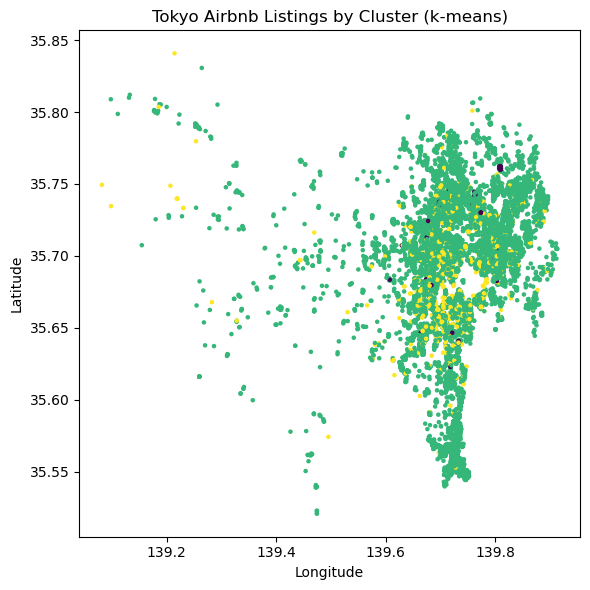

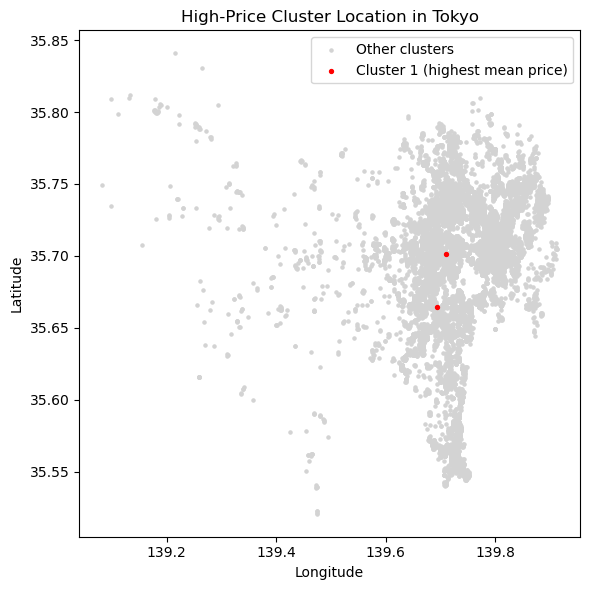

In [12]:
# Question 1 output
df_clustered = load_clustered_data("listings_with_clusters.csv")

mean_price, median_price, high_cluster = analyze_prices_by_cluster(df_clustered)

# Question 2 output
counts, proportions = analyze_room_type_by_cluster(df_clustered)

# Question 3 & 4 output
plot_clusters(df_clustered)
plot_high_price_cluster(df_clustered, high_cluster)

## Clustering Analysis of Tokyo Airbnb Listings Using a Custom K-Means Algorithm

The analysis of Tokyo Airbnb listings reveals pronounced differences among clusters in price levels, room-type composition, and spatial distribution. The mean prices across clusters vary sharply, demonstrating that each cluster represents a distinct market tier. Cluster 1 exhibits the highest mean price at approximately ¥7.9 million, far exceeding the averages of other groups. This extremely high mean is associated with only two listings, indicating that the cluster reflects a narrow subset of exceptionally expensive properties. Cluster 0 and Cluster 3 display mid-range mean prices of roughly ¥533,826 and ¥570,169, while Cluster 2 shows the lowest mean price at approximately ¥148,147. These figures suggest that the clustering separates budget, moderate, and premium listings effectively.

Room-type distributions also differ notably across clusters. Cluster 2—the largest and least expensive group—contains predominantly entire homes or apartments (about 85%), but also a substantial proportion of private rooms and a small share of shared rooms. Cluster 3 includes a similarly high proportion of entire homes or apartments (around 92%), yet it still incorporates some private rooms, indicating moderate variability. In contrast, Clusters 0 and 1 consist almost exclusively of entire homes or apartments. Given their small size, these clusters appear to represent unusual or niche segments of the dataset rather than broad categories of listings. The extremely small size of Cluster 1 helps explain its inflated average price, as the cluster captures only two high-priced listings rather than a representative set of properties.

Spatial patterns observed in the scatter plots further clarify the distinctions among clusters. When all listings are plotted, the data show a dense concentration of points within a central zone of the map, with additional listings spreading outward into less dense peripheral areas. Cluster 1 is located entirely within this densest central area, aligning with locations where listing concentration is highest. The fact that both properties in Cluster 1 fall within the same compact region supports the interpretation that this cluster reflects properties situated in highly active and in-demand urban environments.

Clusters 0 and 3 also occupy the central band of the map but extend into areas of slightly lower density, indicating that these mid-priced listings are distributed both within and just outside the highest-activity areas. In contrast, Cluster 2 spans not only central neighborhoods but also a wide peripheral arc, stretching into areas where listing density decreases markedly. This wider geographic footprint is consistent with the cluster’s lower price levels, as less dense outer regions typically offer more affordable accommodation options.

Taken together, the pricing statistics, room-type distributions, and spatial patterns suggest that the clustering effectively distinguishes between high-demand central properties, moderately priced mixed-area listings, and more affordable accommodations spread across a larger geographical range. The results reflect a market characterized by strong central concentration, substantial price variation, and diverse accommodation types that align with differing levels of urban activity.